In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import sys
import numpy
import pandas as pd
import tensorflow as tf
from keras import layers
import keras


#taking the model
#from VAE_model_extended_moreDKL import *
from VAE_testDK_Reco_Loss import *
import matplotlib.pyplot as plt

import ROOT

2022-07-22 13:50:55.748619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 13:50:55.748746: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Welcome to JupyROOT 6.26/04


In [2]:
ROOT.ROOT.EnableImplicitMT()
#RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame

### variable from the nutple

In [3]:
#pd_variables = ['deltaetajj', 'deltaphijj', 'etaj1', 'etaj2', 'etal1', 'etal2',
#       'met', 'mjj', 'mll',  'ptj1', 'ptj2', 'ptl1',
#       'ptl2', 'ptll']#,'phij1', 'phij2', 'w']
#kinematicFilter = "ptj1 > 30 && ptj2 >30 && deltaetajj>2 && mjj>200"
kinematicFilter = "ptj1 > 30 && abs(etaj1-etaj2) > 2. && ptj2 >30 && mjj>200"
ntuple_location = "../../ntuples4Momentum/"

In [4]:
dfSM = ROOT.RDataFrame("SSWW_SM",ntuple_location+"ntuple_SSWW_SM.root")
dfSM = dfSM.Filter(kinematicFilter)
dfBSM = ROOT.RDataFrame("SSWW_cW_QU",ntuple_location+"ntuple_SSWW_cW_QU.root")
dfBSM = dfBSM.Filter(kinematicFilter)
np_SM = dfSM.AsNumpy()
wSM = dfSM.AsNumpy(["w"])
npd = pd.DataFrame.from_dict(np_SM)
npd.head(2)

,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,w
0,303.458801,701.662598,66.335213,61.839161,-1.531009,1.705899,-1.010756,0.059856,115.725586,914.647095,...,-46.985771,18.432892,-183.381699,20.959143,40.034378,-276.328735,656.85614,-50.817711,3.697025,0.005543
1,3651.136963,1009.032227,20.087341,50.679325,4.309694,-1.440623,-1.145179,-1.002823,363.730774,3743.060303,...,-30.832169,-93.790749,186.751892,11.565145,-11.108819,3649.818604,-901.89624,-16.394295,-38.657024,0.005543


In [5]:
npd.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)
npd.head(2)

,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl1,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2
0,303.458801,701.662598,66.335213,61.839161,-1.531009,1.705899,-1.010756,0.059856,115.725586,914.647095,...,37.129974,-46.985771,18.432892,-183.381699,20.959143,40.034378,-276.328735,656.85614,-50.817711,3.697025
1,3651.136963,1009.032227,20.087341,50.679325,4.309694,-1.440623,-1.145179,-1.002823,363.730774,3743.060303,...,-0.987826,-30.832169,-93.790749,186.751892,11.565145,-11.108819,3649.818604,-901.89624,-16.394295,-38.657024


In [6]:
wpdSM = pd.DataFrame.from_dict(wSM)
wpdSM.head(2)
# npd.info()

,w
0,0.005578
1,0.005578


In [7]:
# Take all columns og dfBSM because of using RDateFrame.AsNumpy() without any filter
np_BSM = dfBSM.AsNumpy()
wBSM = dfBSM.AsNumpy(["w"])
npd_BSM = pd.DataFrame.from_dict(np_BSM)
npd_BSM.head(2)

,Ej1,Ej2,El1,El2,etaj1,etaj2,etal1,etal2,met,mjj,...,pxl2,pyj1,pyj2,pyl1,pyl2,pzj1,pzj2,pzl1,pzl2,w
0,800.932922,3766.025879,42.786198,499.031891,-2.564578,3.370996,0.230144,0.919019,30.624445,3454.649170,...,-229.171600,118.484314,134.396973,-26.105608,-255.849304,-791.503235,3757.146240,9.676733,362.014282,0.003932
1,1141.393799,926.677429,343.436157,715.718445,2.678149,-2.400338,1.294819,-1.300454,195.658157,2030.949951,...,-351.055298,-118.407394,-130.242081,161.676956,-92.347092,1130.673462,-911.559448,295.486816,-616.834717,0.003932


In [8]:
npd_BSM.drop(['w','phil1','phil2',"phij1","phij2"],axis='columns', inplace=True)
wpdBSM = pd.DataFrame.from_dict(wBSM)
wpdBSM.head(2)

,w
0,0.003936
1,0.003936


In [9]:
nEntries = 3000000
npd = npd.head(nEntries)
npd_BSM = npd_BSM.head(nEntries)
wpdSM = wpdSM.head(nEntries)
wpdBSM = wpdBSM.head(nEntries)

In [10]:
# #to be done for all the pt and mass and met variables
for var in ['met', 'mjj', 'mll',  'ptj1', 'ptj2', 'ptl1',
            'ptl2', 'ptll',"Ej1","Ej2","El1","El2"]:
   npd[var] = np.log10(npd[var])
   npd_BSM[var] = np.log10(npd_BSM[var])

In [12]:
Y_true = np.full(npd.shape[0],0)
Y_true_BSM = np.full(npd_BSM.shape[0],1)
#concatenating SM and BSM
samples = np.concatenate((npd,npd_BSM))
labels = np.concatenate((Y_true,Y_true_BSM))

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.2, random_state=1)
SM_train,SM_test,_,_ = train_test_split(npd, npd, test_size=0.2, random_state=1)
BSM_train,BSM_test,_,_ = train_test_split(npd_BSM, npd_BSM, test_size=0.2, random_state=1)
#wx_train, wx_test, wy_train, wy_test = train_test_split(wpdSM, wpdSM, test_size=0.2, random_state=1)

#BSM_train, BSM_test, y_BSM_train, y_BSM_test = train_test_split(npd_BSM, Y_true_BSM, test_size=0.2, random_state=1)
#wBSM_train, wBSM_test, _ , _ = train_test_split(wpdBSM, wpdBSM, test_size=0.2, random_state=1)
#print wx_train,X_train
#wx = wx_train["w"].to_numpy()
#wxtest = wx_test["w"].to_numpy()
#wBSM = wBSM_train["w"].to_numpy()
#wBSMtest = wBSM_test["w"].to_numpy()

In [13]:
# scale data

scaler = MinMaxScaler()
#scaler = StandardScaler()
scaler.fit(SM_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
BSM_test = scaler.transform(BSM_test)

/home/nika/anaconda3/envs/root_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/nika/anaconda3/envs/root_environment/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [14]:
n_inputs = npd.shape[1]
original_dim = n_inputs

intermediate_dim = 50 #50 by default
input_dim = 10 #was 20 in default
half_input = 7 #was 20 in the newTest
latent_dim = 10 #tried 7 as well  #was 3 for optimal performance
epochs = 20 #80
batch_size=64 #32
nameExtenstion = str(intermediate_dim) + "_" +\
                 str(input_dim) + "_" +\
                 str(half_input) + "_" +\
                 str(latent_dim) + "_" +\
                 str(epochs) + "_" +\
                 str(batch_size)


In [15]:
vae = VariationalAutoEncoder(original_dim, 
                             intermediate_dim, 
                             input_dim, 
                             half_input, 
                             latent_dim,
                             )  
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  
#               loss=tf.keras.losses.MeanSquaredError()
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#               run_eagerly=True, loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
#vae.compile(
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
#               loss_weights=[0.1],loss="binary_crossentropy",
#               metrics = [tf.keras.metrics.BinaryAccuracy()]
#           )
vae.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss="binary_crossentropy",
                metrics = [tf.keras.metrics.BinaryAccuracy()]
            )
hist = vae.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=epochs, batch_size = batch_size) 
#print "new model: ", vae.summary()
encoderDecoder =  EncoderDecoder(original_dim,intermediate_dim,input_dim,half_input,latent_dim)
reco = encoderDecoder.predict(X_test)
#encoder = LatentSpace(intermediate_dim,input_dim,half_input,latent_dim)
#z = encoder.predict(X_train)

Epoch 1/20
19381/19381 [==============================] - 154s 8ms/step - loss: 0.3693 - binary_accuracy: 0.8654 - val_loss: 0.3174 - val_binary_accuracy: 0.8880
Epoch 2/20
19381/19381 [==============================] - 155s 8ms/step - loss: 0.3136 - binary_accuracy: 0.8887 - val_loss: 0.3109 - val_binary_accuracy: 0.8896
Epoch 3/20
19381/19381 [==============================] - 159s 8ms/step - loss: 0.3092 - binary_accuracy: 0.8895 - val_loss: 0.3073 - val_binary_accuracy: 0.8895
Epoch 4/20
19381/19381 [==============================] - 162s 8ms/step - loss: 0.3066 - binary_accuracy: 0.8901 - val_loss: 0.3079 - val_binary_accuracy: 0.8899
Epoch 5/20
19381/19381 [==============================] - 159s 8ms/step - loss: 0.3038 - binary_accuracy: 0.8905 - val_loss: 0.3014 - val_binary_accuracy: 0.8923
Epoch 6/20
19381/19381 [==============================] - 159s 8ms/step - loss: 0.3013 - binary_accuracy: 0.8908 - val_loss: 0.3045 - val_binary_accuracy: 0.8890
Epoch 7/20
19381/19381 [====

2022-07-20 11:52:03.042181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 11:52:03.042252: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 11:52:03.042323: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2022-07-20 11:52:03.042966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 11:52:03.146782: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 138917856 exceeds

In [16]:
keras.models.save_model(encoderDecoder,'encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
keras.models.save_model(vae,'vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_'+nameExtenstion)
#numpy.savetxt("lossVAE_test_newModelDimenstions_MinMaxScaler_"+nameExtenstion+".csv",hist.history["loss"],delimiter=",")
#vae=tf.keras.models.load_model('vae_test_newModelUsingLatentSpace_'+nameExtenstion)

INFO:tensorflow:Assets written to: encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: encoderDecoder_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


INFO:tensorflow:Assets written to: vae_newModelUsingKL_Reco_Loss_newWayToAddUpSamples_50_10_7_10_20_64/assets


In [17]:
output_SM = vae.predict(X_test)
output_BSM = vae.predict(BSM_test)

4091/4091 [==============================] - 14s 3ms/step


In [20]:
print(output_SM)

[[0.15316768]
 [0.54910475]
 [0.8085883 ]
 ...
 [0.02492769]
 [0.97000456]
 [0.42212707]]


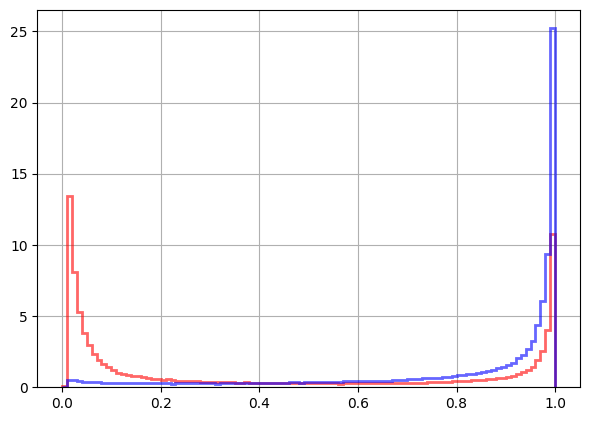

In [18]:
#print output_SM
#print output_BSM
bins=100
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.hist(output_SM,bins=bins, density=1,range=[0.,1.],histtype="step",color="red",alpha=0.6,linewidth=2,label="SM Output")                        
ax.hist(output_BSM,bins=bins, density=1,range=[0.,1.],histtype="step",color="blue",alpha=0.6,linewidth=2,label="BSM Output")                        
plt.rc('legend',fontsize='small')    
plt.show()

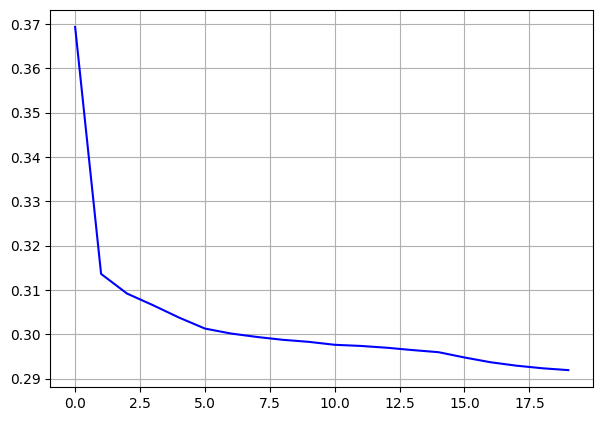

In [19]:
x_bins = range(len(hist.history["loss"]))
ax = plt.figure(figsize=(7,5), dpi=100, facecolor="w").add_subplot(111)
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")
ax.plot(x_bins,hist.history["loss"],color="blue",label="training losss")                        
plt.rc('legend',fontsize='small')    
plt.show()